### Prologue

*"The Earth is a very small stage in a vast cosmic arena." - Carl Sagan*

# Near-Earth Objects Classification and Risk Assessment: An Exploratory Study

##### *by Yusuf Abolarinwa*

#### - Overview

**Near-Earth Objects (NEOs)** are asteroids or comets whose orbits bring them close to Earth. Many originate in the asteroid belt but are gradually displaced by gravitational interactions or collisions. Tracking and assessing these objects require precise data collection and continuous refinement of their trajectories.

A recent example is the discovery of Asteroid 2024 YR24 on December 22, 2024, by the ATLAS telescope in Río Hurtado, Chile. Initially, concerns were raised about its estimated 40–90m diameter and potential impact risk. As a result, it was downgraded from Level 3 to Level 0 on the Torino Impact Hazard Scale, meaning it no longer poses a significant threat. This pattern is common since early impact probability estimates tend to fluctuate before stabilizing with improved data.


### - Problem statement

Accurate impact risk assessment of **Near-Earth Objects (NEOs)** relies on well-structured and high-quality data. However, raw astronomical datasets often contain **missing values, inconsistencies, and irrelevant features**, making it challenging to develop reliable predictive models. Without proper data preprocessing, impact probability estimates can be misleading, leading to unnecessary concerns or overlooked threats.  

This project addresses these challenges by conducting exploratory data analysis (EDA) and data preparation, ensuring that NEO datasets are cleaned, standardized, and optimized for predictive modeling. Additionally, we explore feature importance and statistical validation techniques, such as SHAP analysis, correlation analysis, and the Mann-Whitney U test, to uncover key drivers of NEO or asteroid hazard classification.




#### - Data availability statement


Publicly avalable data were analysed in this study. This data can be found at: https://www.kaggle.com/datasets/ivansher/nasa-nearest-earth-objects-1910-2024

### - Import necessary libraries

In [1]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import shap
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import mannwhitneyu

### - Load & Inspect Data

Here I pulled out the NEOs data from my PC using the `read,csv( )` method, and conducted a quick eyeballing exercise to have an understanding of the data shape, completeness, and other key attributes.

In [2]:
df_raw = pd.read_csv("C:\\Users\\DELL\\Desktop\\Hazardous NEOs\\data\\raw\\nearest-earth-objects(1910-2024).csv")
df_raw

,neo_id,name,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,orbiting_body,relative_velocity,miss_distance,is_hazardous
0,2162117,162117 (1998 SD15),19.140,0.394962,0.883161,Earth,71745.401048,5.814362e+07,False
1,2349507,349507 (2008 QY),18.500,0.530341,1.185878,Earth,109949.757148,5.580105e+07,True
2,2455415,455415 (2003 GA),21.450,0.136319,0.304818,Earth,24865.506798,6.720689e+07,False
3,3132126,(2002 PB),20.630,0.198863,0.444672,Earth,78890.076805,3.039644e+07,False
4,3557844,(2011 DW),22.700,0.076658,0.171412,Earth,56036.519484,6.311863e+07,False
...,...,...,...,...,...,...,...,...,...
338194,54403809,(2023 VS4),28.580,0.005112,0.011430,Earth,56646.985988,6.406548e+07,False
338195,54415298,(2023 XW5),28.690,0.004859,0.010865,Earth,21130.768947,2.948883e+07,False
338196,54454871,(2024 KJ7),21.919,0.109839,0.245607,Earth,11832.041031,5.346078e+07,False
338197,54456245,(2024 NE),23.887,0.044377,0.099229,Earth,56198.382733,5.184742e+06,False


### - Dataset description

* `neo_id` >> Unique identifier for each Near-Earth Object (NEO)

* `name` >> Name/designation of the NEO

* `absolute_magnitude` >> Intrinsic brightness of the NEO (lower values indicate higher brightness)

* `estimated_diameter_min` >> Minimum estimated diameter of the NEO (in km or meters)

* `estimated_diameter_max` >> Maximum estimated diameter of the NEO (in km or meters)

* `orbiting_body` >> The celestial body around which the NEO or asteroid orbits (e.g., Earth)

* `relative_velocity` >> Speed of the NEO relative to Earth (in km/s)

* `miss_distance` >> Closest distance of the NEO to Earth (in km or AU)

* `is_hazardous` >> Binary classification indicating whether the NEO is considered potentially hazardous (1 = Yes, 0 = No)

In [3]:
# Counts the number of missing values in individual features
df_raw.isnull().sum()

neo_id                     0
name                       0
absolute_magnitude        28
estimated_diameter_min    28
estimated_diameter_max    28
orbiting_body              0
relative_velocity          0
miss_distance              0
is_hazardous               0
dtype: int64

The result shows three of the nine features; `absolute_magnitude`, `estimated_diameter_min`,`estimated_diameter_max` in the data have 28 empty entries/missing values or NaNs

In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338199 entries, 0 to 338198
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   neo_id                  338199 non-null  int64  
 1   name                    338199 non-null  object 
 2   absolute_magnitude      338171 non-null  float64
 3   estimated_diameter_min  338171 non-null  float64
 4   estimated_diameter_max  338171 non-null  float64
 5   orbiting_body           338199 non-null  object 
 6   relative_velocity       338199 non-null  float64
 7   miss_distance           338199 non-null  float64
 8   is_hazardous            338199 non-null  bool   
dtypes: bool(1), float64(5), int64(1), object(2)
memory usage: 21.0+ MB


In another way, using the `info()` method, I was able to confirmed the presence of missing values in the columns

# Data Preprocessing

Transforming raw data into a structured, analysis-ready format is essential in any data analysis task. By preprocessing the data, we eliminate inherent noise, strengthen data integrity to draw meaningful insights. It is a crucial step in machine learning that prepare datasets for accurate modeling and interpretation.

Unfortunately, it is not a one-way street or a linear process. There is a lot of back and forth trying to normalize or put the data in the right format. With this in mind, I wrote a function that store all the necessary data preprocessing activities under a single umbrella `wrangle( )`. This helps me save my time & in being organized with cleaning and preparing the data.

In [5]:
def wrangle(filepath):
  
  # Read in the Neos data
  df_raw = pd.read_csv(filepath)
  
  # Compute medians of numeric columns only
  medians = df_raw.select_dtypes(include=["number"]).median()

  # Fill missing values with computed medians
  df_raw.fillna(medians, inplace=True)
  
  # Drop duplicates 
  df_raw.drop_duplicates(inplace=True)
   
  # Feature engineering: creating new ratio feature
  df_raw["velocity_to_diameter_ratio"]= (df_raw["relative_velocity"] / df_raw["estimated_diameter_min"])/1e7
  
  # Rename binary target, PHOs  with "0" and "1"
  df_raw["phos"] = (df_raw["is_hazardous"]).astype(int)
  
  # Drop the redundant columns 
  df_raw.drop(
    columns=[
    "name",
    "is_hazardous",
    "neo_id", 
    "orbiting_body",
    "estimated_diameter_min"
    ], 
    inplace=True)

  # Formatting the scientific notation in "miss_distance" column
  df_raw["miss_distance"] = (df_raw["miss_distance"])/1e7
  
  return df_raw


In [6]:
df_cleaned = wrangle("C:\\Users\\DELL\\Desktop\\Hazardous NEOs\\data\\raw\\nearest-earth-objects(1910-2024).csv")
df_cleaned.head()

,absolute_magnitude,estimated_diameter_max,relative_velocity,miss_distance,velocity_to_diameter_ratio,phos
0,19.14,0.883161,71745.401048,5.814362,0.018165,0
1,18.50,1.185878,109949.757148,5.580105,0.020732,1
2,21.45,0.304818,24865.506798,6.720689,0.018241,0
3,20.63,0.444672,78890.076805,3.039644,0.039670,0
4,22.70,0.171412,56036.519484,6.311863,0.073100,0


In [7]:
df_cleaned.shape

(338199, 6)

In [8]:
# Post-Cleaning: Double-check on the data
df_cleaned.isnull().sum()

absolute_magnitude            0
estimated_diameter_max        0
relative_velocity             0
miss_distance                 0
velocity_to_diameter_ratio    0
phos                          0
dtype: int64

# Exploratory Data Analysis (EDA)

In this section, I conducted an in-depth analysis to explore the distribution and relationships of key features in the NEOs data. Through statistical summaries and visualizations, I examined patterns, correlations, and potential outliers, gaining insights into how factors or features like velocity, diameter, and miss distance influence the classification of Near-Earth Objects as either being hazardous or non-hazardous.

###  - Detect Outliers 

#### (i) Boxplots

Boxplot is an effective tool to identify outliers or strongly skewed data. It summarizes our data in five statistics while also showing the unusual observations.

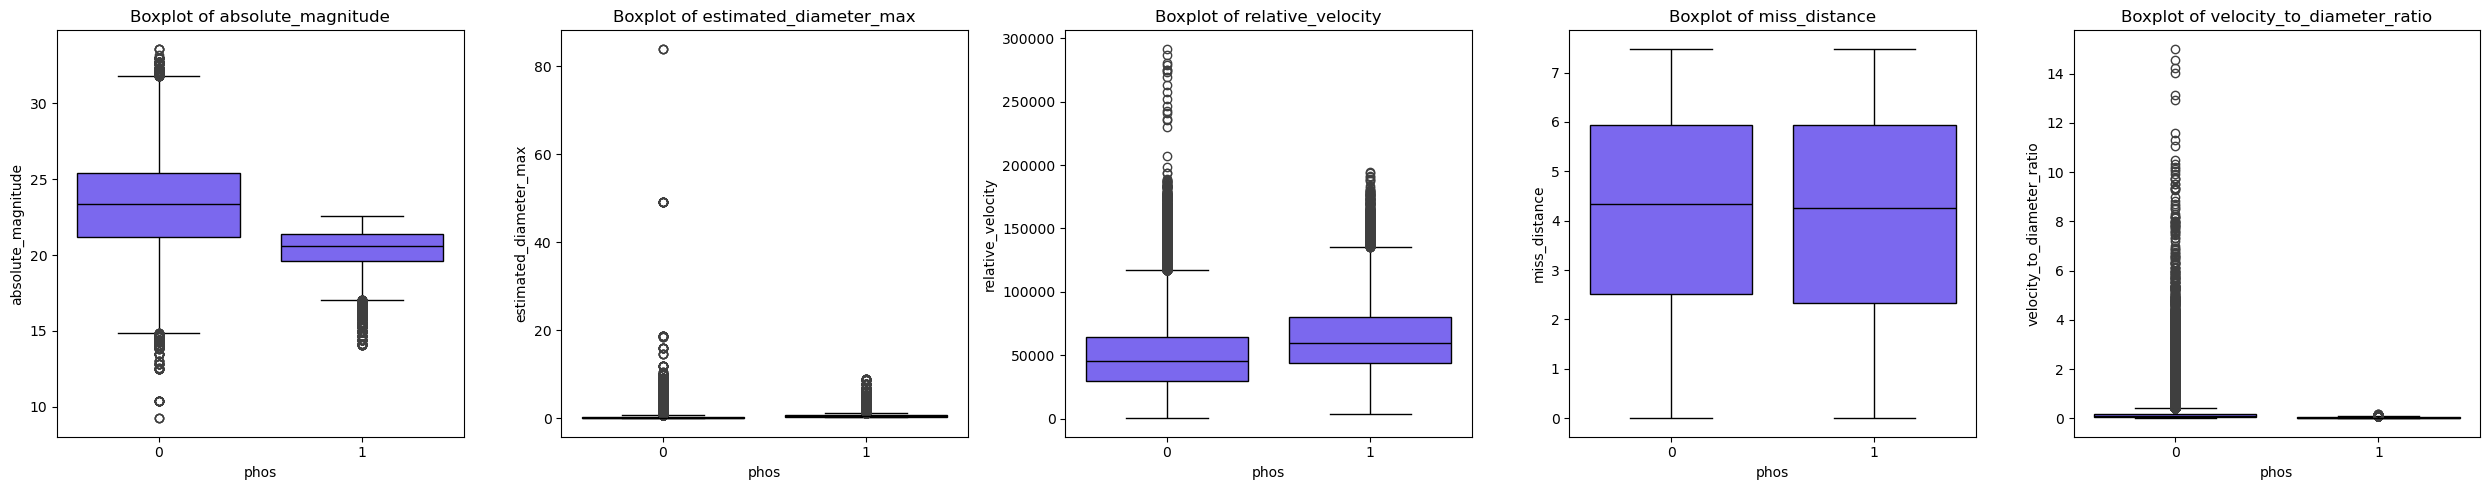

In [9]:
# Ensure only 5 features are selected
features = df_cleaned.iloc[:, :-1].columns[:5]

# Define subplot layout dynamically
num_features = len(features)
fig, axes = plt.subplots(1, num_features, figsize=(5 * num_features, 5), squeeze=False)

# Loop through each feature and create a boxplot
for i, feature in enumerate(features):
    sns.boxplot(x="phos", y=feature, data=df_cleaned, ax=axes[0, i], 
                boxprops={"facecolor": "mediumslateblue", "edgecolor": "black"}, 
                medianprops={"color": "black"}, 
                whiskerprops={"color": "black"}, 
                capprops={"color": "black"})
    
    axes[0, i].set_title(f"Boxplot of {feature}")

plt.tight_layout()
plt.show()

* Looking at the boxplots above, we have features with extreme values//Outliers.

#### (ii) Solving the Outliers Problem

Using the `describe()` method on the dataframe, we can have closer look at how extreme the outliers are in our data.

In [10]:
# Feature Summary Statistics
df_cleaned.describe().iloc[1:]

,absolute_magnitude,estimated_diameter_max,relative_velocity,miss_distance,velocity_to_diameter_ratio,phos
mean,22.932514,0.352863,51060.662908,4.153535,0.148469,0.127623
std,2.911096,0.701842,26399.238435,2.077399,0.301633,0.333670
min,9.250000,0.001143,203.346433,0.000675,0.000059,0.000000
25%,20.740000,0.056760,30712.031471,2.494540,0.026641,0.000000
50%,22.800000,0.163697,47560.465474,4.332674,0.059463,0.000000
75%,25.100000,0.422708,66673.820614,5.933961,0.155454,0.000000
max,33.580000,83.953727,291781.106613,7.479865,15.013349,1.000000


Rule to curb outliers:

* Restrict columns with max values many standard deviation away from the mean.

* The columns to address include: `absolute_magnitude`, `relative_velocity`,`velocity_to_diameter_ratio`, & `estimated_diameter_max`

In [11]:
print(np.mean(df_cleaned['absolute_magnitude'])+ 2*np.std(df_cleaned['absolute_magnitude']))
print(np.mean(df_cleaned['relative_velocity'])+ 2*np.std(df_cleaned['relative_velocity']))
print(np.mean(df_cleaned['velocity_to_diameter_ratio'])+ 2*np.std(df_cleaned['velocity_to_diameter_ratio']))
print(np.mean(df_cleaned['estimated_diameter_max'])+ 2*np.std(df_cleaned['estimated_diameter_max']))

28.75469763005892
103859.0617190386
0.7517339031186923
1.7565438484020561


In [12]:
# Create a copy of the cleaned dataframe
df0 = df_cleaned.copy()

# Use `df0` instead of `df_cleaned` in the cutoffs condition
cutoffs = (
    (df0["absolute_magnitude"] < 28.7) &
    (df0["relative_velocity"] < 100_000) &
    (df0["velocity_to_diameter_ratio"] < 0.7) &
    (df0["estimated_diameter_max"] < 1.7)
)

df0 = df0[cutoffs]

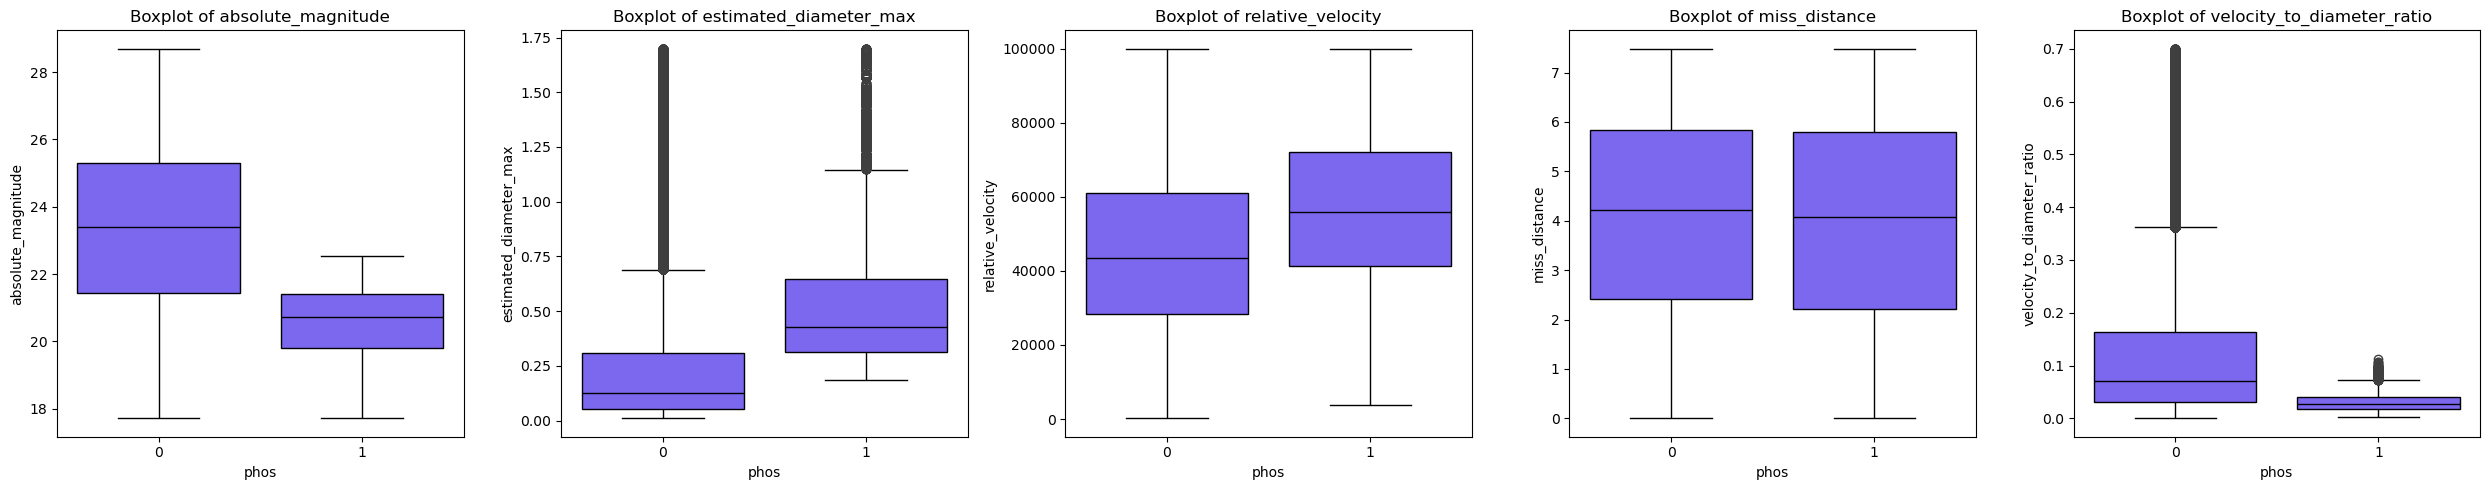

In [13]:
# Ensure only 5 features are selected
features0 = df0.iloc[:, :-1].columns[:5]

# Define subplot layout dynamically
num_features = len(features0)
fig, axes = plt.subplots(1, num_features, figsize=(5 * num_features, 5), squeeze=False)

# Loop through each feature and create a boxplot
for i, feature in enumerate(features0):
    sns.boxplot(x="phos", y=feature, data=df0, ax=axes[0, i], 
                boxprops={"facecolor": "mediumslateblue", "edgecolor": "black"}, 
                medianprops={"color": "black"}, 
                whiskerprops={"color": "black"}, 
                capprops={"color": "black"})
    
    axes[0, i].set_title(f"Boxplot of {feature}")

plt.tight_layout()
plt.show()

* Hazardous asteroids tend to be **larger, brighter (lower absolute magnitude), and move faster** on average.

* **velocity-to-diameter ratios are lower and more concentrated**, meaning they are relatively large but not disproportionately fast. Non-hazardous asteroids show **greater variability** in size and speed, with more extreme outliers. 
* The presence of long tail with extreme values in **velocity-to-diameter** & **estimated_diameter_max** indicates a right-skewed distribution (+ve skew)
* Overall, size, brightness, and velocity are key distinguishing factors between the two categories.

In [14]:
df = df0.copy()
df.shape

(301551, 6)

In [15]:
# Feature Summary Statistics
df.describe().iloc[1:]

,absolute_magnitude,estimated_diameter_max,relative_velocity,miss_distance,velocity_to_diameter_ratio,phos
mean,22.983412,0.276493,47060.905013,4.067631,0.111412,0.121631
std,2.530547,0.308880,21690.541044,2.066988,0.128603,0.326860
min,17.720000,0.010865,203.346433,0.001865,0.000087,0.000000
25%,20.960000,0.059435,29613.998481,2.398755,0.027353,0.000000
50%,22.900000,0.156329,45187.830781,4.206922,0.059000,0.000000
75%,25.000000,0.381979,62540.373250,5.828716,0.144582,0.000000
max,28.690000,1.698400,99996.838788,7.479865,0.699960,1.000000


### - Data distribution 

(a) Distribution of Potentially Hazardous Objects (PHOs)

In [16]:
df["phos"].value_counts().to_frame()

,count
phos,
0,264873
1,36678


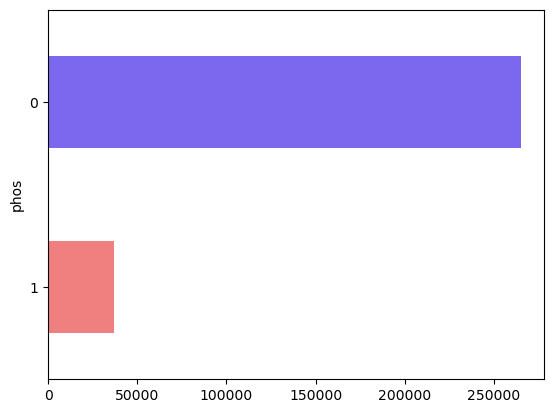

In [17]:
df["phos"].value_counts().sort_values().plot(kind="barh", color=["lightcoral", "mediumslateblue"]);

* Out of all recorded asteroids or NEOs, over 200,000 are classified as non-hazardous, while 36,678 are considered hazardous.

(ii) Proportion of PHOs and non-PHOs

In [18]:
df["phos"].value_counts(normalize=True).to_frame()

,proportion
phos,
0,0.878369
1,0.121631


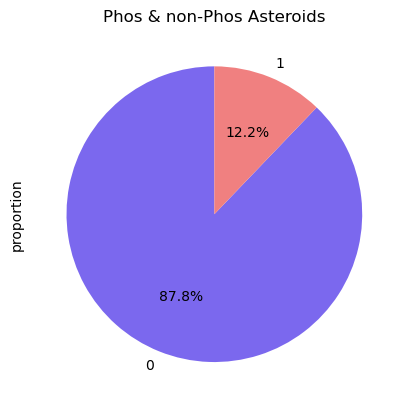

In [19]:
df["phos"].value_counts(normalize=True).plot(
    kind="pie", autopct='%1.1f%%', startangle=90, 
    title="Phos & non-Phos Asteroids", colors=["mediumslateblue", "lightcoral"]);

* 87.8% of the asteroids or NEOs are potentially non-hazardous objects (non-Phos). 
* This shows that the *target class* is `imbalanced`, as the distribution of values in non-phos is significantly larger than phos.



(b) Estimated diameter & Velocity ratio

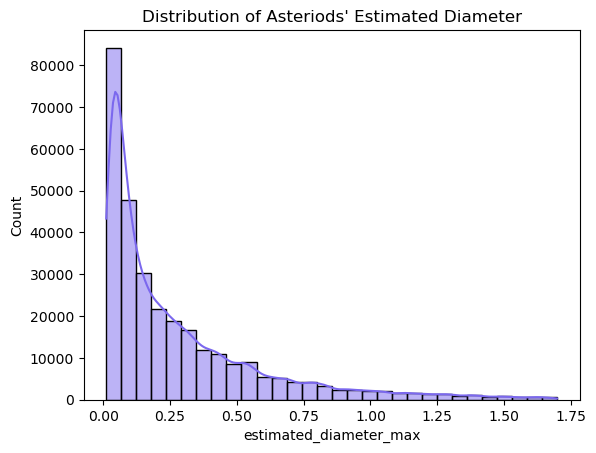

In [20]:
sns.histplot(df["estimated_diameter_max"], bins=30, kde=True, color="mediumslateblue")
plt.title("Distribution of Asteriods' Estimated Diameter")
plt.show();

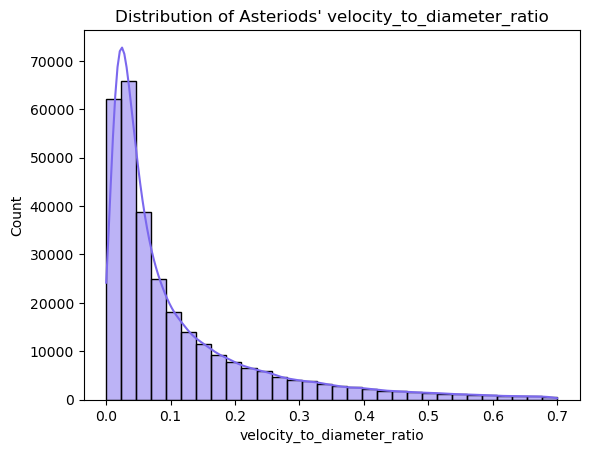

In [21]:
sns.histplot(df["velocity_to_diameter_ratio"], bins=30, kde=True, color="mediumslateblue")
plt.title("Distribution of Asteriods' velocity_to_diameter_ratio")
plt.show();

* The distribution of asteroids' estimated maximum diameter & velocity_to_diameter is right-skewed (positively skewed)

* Most asteroids or NEOs are small in size, with a gradual decrease in frequency as size increases.

* Most asteroids move at relatively low speeds compared to their diameters, while a few have unusually high ratios

### - Scatter Plot

(a)

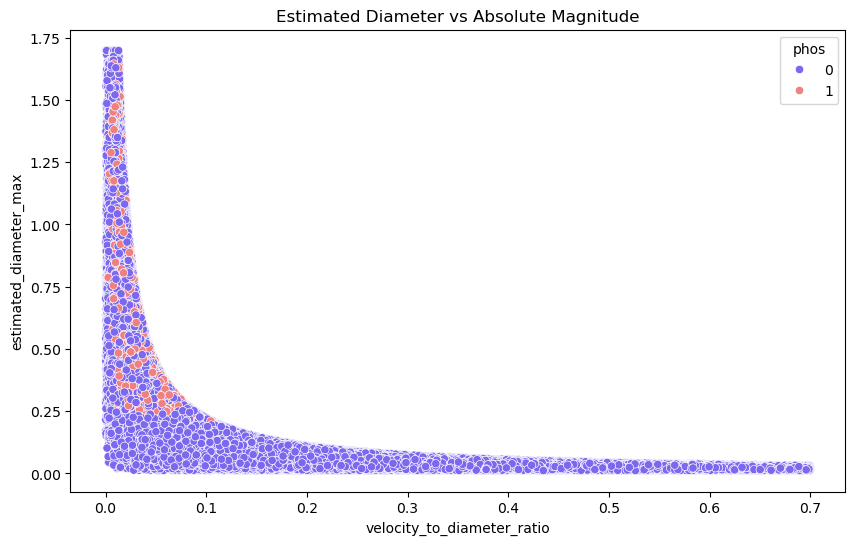

In [22]:
# Scatter plot of Estimated Diameter vs Absolute Magnitude
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='velocity_to_diameter_ratio', 
    y='estimated_diameter_max', 
    hue='phos', 
    data=df, 
    palette=['mediumslateblue', 'lightcoral']  # Custom colors
)
plt.title('Estimated Diameter vs Absolute Magnitude')
plt.show()

* As expected, the data is highly skewed, with most asteroids having a low velocity-to-diameter ratio

* As the velocity-to-diameter ratio increases, the estimated diameter tends to be very small.

* Larger asteroids move relatively slower compared to their size, while smaller asteroids exhibit a broader velocity-to-diameter ratio.


(b)

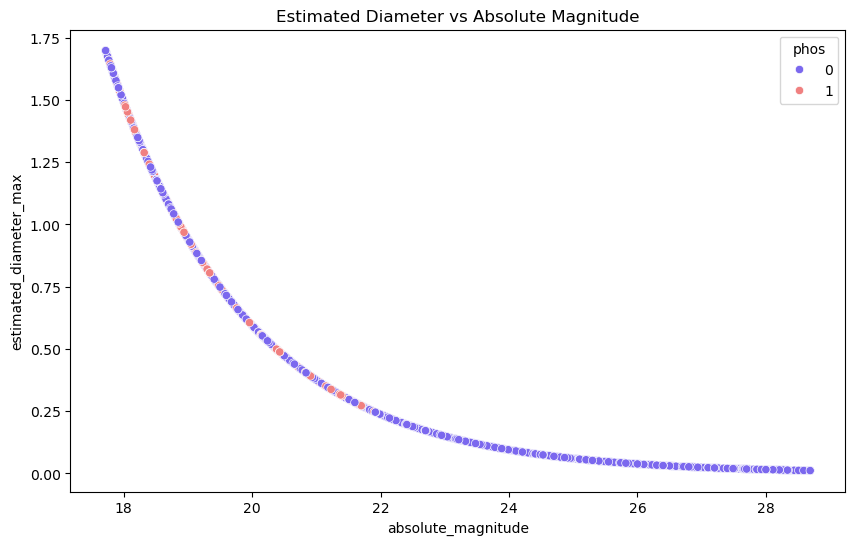

In [23]:
# Scatter plot of Estimated Diameter vs Absolute Magnitude
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='absolute_magnitude', 
    y='estimated_diameter_max', 
    hue='phos', 
    data=df, 
    palette=['mediumslateblue', 'lightcoral']  
)
plt.title('Estimated Diameter vs Absolute Magnitude')
plt.show()

* There is a strong relationship between absolute magnitude and estimated diameter max.

* The correlation follows a power-law decay pattern, meaning *larger asteroids tend to have lower absolute magnitudes*.

* It shows that larger asteroids are more likely to be classified as potentially hazardous.

### - Correlarion matrix

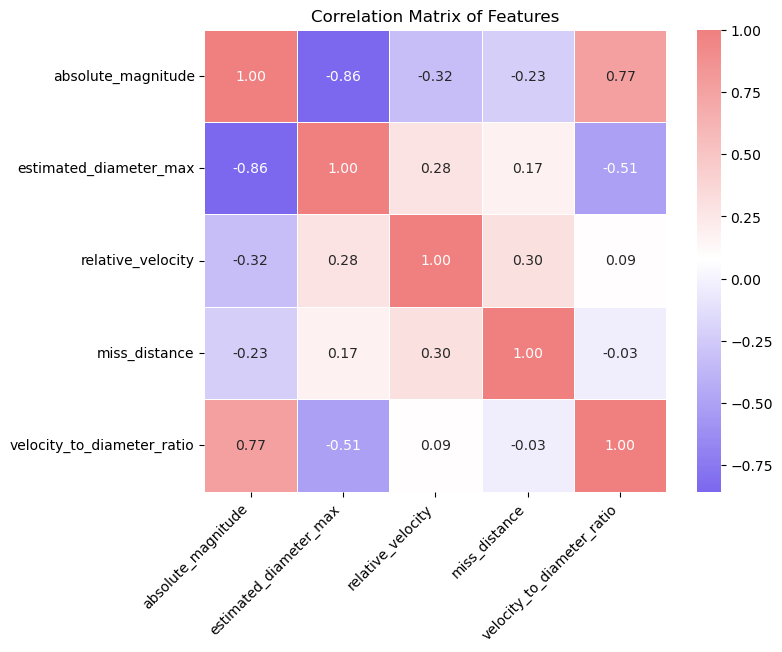

In [24]:
from matplotlib.colors import LinearSegmentedColormap

# Custom colormap
cmap = LinearSegmentedColormap.from_list("custom", ["mediumslateblue", "white", "lightcoral"])

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df.drop(columns="phos").corr(), annot=True, cmap=cmap, fmt=".2f", linewidths=0.5, square=True)

plt.title("Correlation Matrix of Features", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.show()

* Just as revealed by the scatter plot above, a strong negative correlation between absolute magnitude and diameter aligns with astronomical principles: *brighter asteroids (lower absolute magnitude) are generally larger.*

* velocity-to-diameter ratio is more strongly tied to magnitude and diameter, suggesting that smaller, faster asteroids have different impact risks

### - Features Importance with SHAP

A SHAP (SHapley Additive Explanations) summary plot shows how different features impact the model's output. +ve SHAP values push the model’s output higher (e.g., more likely to classify as hazardous), while negative values decrease it.

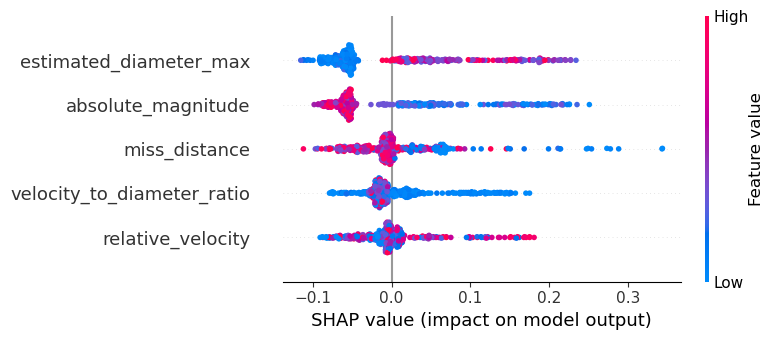

In [25]:
# Define features and target
X = df.drop(columns=["phos"])  # Features
y = df["phos"]  # Binary target for Potentially Hazardous Objects or Asteroids

# Reduce dataset size (randomly select 500 samples)
X_sample = X.sample(500, random_state=42)
y_sample = y.loc[X_sample.index]  # Ensure matching labels

# Train Random Forest Model on the smaller dataset
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_sample, y_sample)

# Compute SHAP values using TreeExplainer
explainer = shap.TreeExplainer(rf)
shap_values = explainer(X_sample)  

# Extract correct SHAP values for binary classification
shap_values_class_1 = shap_values[:, :, 1]  # Extract last dimension (class 1)

# Plot Summary
shap.summary_plot(shap_values_class_1, X_sample)

`Interpretation`

* Larger asteroids (high estimated diameter max) are more likely classified as hazardous.

* Absolute magnitude influences predictions inversely, since brighter objects tend to be larger

# Hypotheses + test of significance

### On asteroids Diameter and Velocity

* Do larger asteroids generally pose a higher risk compared to smaller ones?

* How does the speed of an asteroid or NEO affect its potential hazard to Earth?

`Null Hypothesis (H₀):` *Median values of hazardous NEOs* `is not larger than` *Median values of non-hazardous NEOs*


`Alternative Hypothesis (H₁):` *Median values of hazardous NEOs* `is larger than` *Median values of non-hazardous NEOs*


`Decision Rule:` If  P-value is lesser than 0.05, we reject the null hypothesis H₀, meaning hazardous NEOs are significantly larger.

In [26]:
# List of features to test
diameter_velocity = ['estimated_diameter_max', 'relative_velocity']

# Initialize lists to store results
feature_names = []
u_statistics = []
p_values = []
effect_sizes = []

# Loop through each feature and perform Mann-Whitney U test
for i in diameter_velocity:
    hazardous = df[df['phos'] == 1][i]
    non_hazardous = df[df['phos'] == 0][i]
    
    # Mann-Whitney U Test (alternative='greater' checks if hazardous NEOs have larger values)
    u_stat, p_val = mannwhitneyu(hazardous, non_hazardous, alternative='greater')
    
    # Calculate Cliff's Delta (effect size)
    n_hazardous = len(hazardous)
    n_non_hazardous = len(non_hazardous)
    cliff_delta = (2 * u_stat - n_hazardous * n_non_hazardous) / (n_hazardous * n_non_hazardous)
    
    # Store results in lists
    feature_names.append(i)
    u_statistics.append(u_stat)
    p_values.append(p_val)
    effect_sizes.append(cliff_delta)

# Create DataFrame
mann_whit_results = pd.DataFrame({
    'Feature': feature_names,
    'U Statistic': u_statistics,
    'P-value': p_values,
    'Effect Size (Cliff\'s Delta)': effect_sizes
})

# Display the DataFrame
print(mann_whit_results)


                  Feature   U Statistic  P-value  Effect Size (Cliff's Delta)
0  estimated_diameter_max  8.046649e+09      0.0                     0.656539
1       relative_velocity  6.302576e+09      0.0                     0.297492


`Interpretation`
* p-value of 0.0 suggests that both larger diameters and higher relative velocities are strong indicators of hazardous asteroids or NEOs. 
* Asteroids or NEOs with large diameter may cause serious damage if a collision with Earth occurs.
* Hazardous NEOs with higher velocities have greater impact due to their speed.


### On asteroids or NEOs brightness and nearness to Earth

* Do asteroids with lower absolute magnitude, *i.e. brighter asteroids* generally pose a higher risk compared to those with higher absolute magnitude?

* How does the proximity (miss distance) of an asteroid or NEO influence its potential hazard to Earth?

`Null Hypothesis (H₀):` *Median values of hazardous NEOs* `is not less than` *Median values of non-hazardous NEOs*

`Alternative Hypothesis (H₁):` *Median values of hazardous NEOs* `is less than` *Median of non-hazardous NEOs*

`Decision Rule:` If  P-value is lesser than 0.05, we reject the null hypothesis H₀, meaning hazardous NEOs are significantly lower values.

In [27]:
# List of features to test
abs_mag_miss_dist = ['absolute_magnitude','miss_distance']

# Initialize lists to store results
feature_names = []
u_statistics = []
p_values = []
effect_sizes = []

# Loop through each feature and perform Mann-Whitney U test
for i in abs_mag_miss_dist:
    hazardous = df[df['phos'] == 1][i]
    non_hazardous = df[df['phos'] == 0][i]
    
    # Mann-Whitney U Test (alternative='less' checks if hazardous NEOs have smaller values)
    u_stat, p_val = mannwhitneyu(hazardous, non_hazardous, alternative='less')
    
    # Calculate Cliff's Delta (effect size)
    n_hazardous = len(hazardous)
    n_non_hazardous = len(non_hazardous)
    cliff_delta = (2 * u_stat - n_hazardous * n_non_hazardous) / (n_hazardous * n_non_hazardous)
    
    # Store results in lists
    feature_names.append(i)
    u_statistics.append(u_stat)
    p_values.append(p_val)
    effect_sizes.append(cliff_delta)

# Create DataFrame with results
mann_whit_results = pd.DataFrame({
    'Feature': feature_names,
    'U Statistic': u_statistics,
    'P-value': p_values,
    'Effect Size (Cliff\'s Delta)': effect_sizes
})

# Display the results
print(mann_whit_results)


              Feature   U Statistic       P-value  Effect Size (Cliff's Delta)
0  absolute_magnitude  1.668362e+09  0.000000e+00                    -0.656539
1       miss_distance  4.751957e+09  7.129616e-12                    -0.021729


`Interpretation`
* p-value of 0.0 suggests that lower value absolute magnitude and miss distance are strong indicators of hazardous asteroids or NEOs. 
* Brighter (lower value absolute magnitude) NEOs could indicate larger or more reflective asteroids, potentially making them more hazardous.
* Closer proximity (miss distance) increases the likelihood of a future impact with Earth.

### Cliff's Delta effect size for NEOs features

In [29]:
# Data dictionary for effect sizes and features
effect_dict = {'Feature': ['estimated_diameter_max', 'relative_velocity', 'absolute_magnitude', 'miss_distance'],
        'Effect Size': [0.656539, 0.297492, -0.656539, -0.021729]}

# Create DataFrame and plot
fig = px.bar(pd.DataFrame(effect_dict), x='Feature', y='Effect Size', 
             title="Effect Sizes (Cliff's Delta)", color_discrete_sequence=['mediumslateblue'])

# Show the plot
fig.show()

`Interpretation`

* Large effect size (= 0.656539) suggests that hazardous NEOs tend to have significantly larger diameters compared to non-hazardous ones.

* Moderate effect size (= 0.297492) suggests that hazardous NEOs tend to have higher relative velocities, but the distinction is not as strong as diameter.

* Large negative effect size (= = -0.656539) suggests that hazardous NEOs tend to have lower absolute magnitudes (i.e., they are brighter).

* Small negative effect size (= -0.021729) suggests that miss distance does not strongly differentiate hazardous from non-hazardous NEOs.


## **Key Findings**  

- **Class Imbalance**: 

  88% of the recorded Near-Earth Objects (NEOs) are **non-PHOs** (non-hazardous). This indicates a significantly *imbalanced binary target class distribution*. In addition to that, the diameter and velocity-to-diameter ratio of asteroids follow a *right-skewed (positively skewed) distribution*.  

- **Relationships Among Features**:  

  - A strong power-law relationship exists between absolute magnitude (brightness) and estimated diameter implying that *the bigger the NEO or asteroid, the more likely it is to be classified as hazardous.*

  - Smaller, faster asteroids behave differently from larger ones, suggesting varying levels of impact risks based on their velocity and diameter. 

- **Diameter and Velocity of Asteroids**

  - SHAP (SHapley Additive Explanations) on 500 random samples reveals that NEOs with larger estimated diameters are more likely to be classified as PHOs.

  -  Larger NEOs pose a greater risk due to their potential for severe damage in the event of a collision with Earth.

  -  Higher-velocity hazardous NEOs have a greater impact threat due to their speed.

  -  These claims are backed by *Mann-Whitney U tests and Cliff’s Delta effect size*, confirming that size and speed play pivotal roles in classifying hazardous      asteroids.

- **Brightness and Nearness to Earth**

  - Brighter NEOs (lower absolute magnitude) might be larger or more reflective, increasing their chances of being categorized as hazardous.

  - Proximity to Earth (miss distance) is an obvious risk factor, but interestingly, its effect size is minimal; suggesting that distance alone isn’t a strong enough predictor of whether an asteroid is hazardous.

  - Again, statistical validation using *Mann-Whitney U tests and Cliff’s Delta effect size* supports these findings.






# Split & Export

In [ ]:
# Shuffle the dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)  

# Define train-test split ratio
split_index = int(0.8 * len(df))  # 80% train, 20% test

# Split data using iloc
train_set_neos = df.iloc[:split_index]  # First 80% rows
test_set_neos = df.iloc[split_index:]   # Remaining 20% rows

# Save to CSV files
train_set_neos.to_csv("train_set_neos.csv", index=False)
test_set_neos.to_csv("test_set_neos.csv", index=False)

# Reference

  - [Near-Earth-Object | Wikipedia ](https://en.wikipedia.org/wiki/Near-Earth_object)

  - [NEOs Basics | NASA ](https://cneos.jpl.nasa.gov/about/neo_groups.html)

  - [Asteroid 2024 YR4 no longer poses significant impact risk | European Space Agency ](https://www.esa.int/Space_Safety/Planetary_Defence/Asteroid_2024_YR4_no_longer_poses_significant_impact_risk)

  - [ Cliff's delta calculator | University of California San Francisco library](  https://search.library.ucsf.edu/discovery/fulldisplay?docid=cdi_scielo_journals_S1657_92672011000200018&context=PC&vid=01UCS_SAF:UCSF&lang=en&search_scope=DN_and_CI&adaptor=Primo%20Central&query=null,,1,AND&facet=citing,exact,cdi_FETCH-LOGICAL-c446t-50082f28956bdaaf4a39983b6260dc118caa28f2cb93d6e6be5b64416d46a5003&offset=20)

 - [Mann-Whitney U test | Data Lab](https://datatab.net/tutorial/mann-whitney-u-test)

  - [ Effect size for Mann-Whitney U test | Dr. Todd Grande](https://www.youtube.com/watch?v=ILD5Jvmokig)


  - Introduction to Modern Statistics | Mine Çetinkaya-Rundel and Johanna Hardin



  